# Croissance économique et Santé
--- 
##### Par Thibaut LAUNAY, Jeanne LEMASSON et Christophe REY

# Introduction
---
Ce projet s’inscrit dans le prolongement d’un débat ancien et toujours très actif en macroéconomie et en économie du développement, concernant les liens entre la croissance économique et l’état de santé des populations. La croissance du PIB est souvent présentée comme un levier essentiel d’amélioration du bien-être, notamment par l’augmentation des revenus, l’élargissement de l’assiette fiscale et le financement accru des systèmes de santé. De nombreux travaux empiriques mettent ainsi en évidence une corrélation positive entre le niveau de revenu par habitant et divers indicateurs de santé, tels que l’espérance de vie ou la mortalité infantile.

Cependant, cette relation est loin d’être univoque. D’une part, les limites du PIB comme indicateur synthétique du bien-être sont désormais largement reconnues, et une croissance soutenue ne garantit pas nécessairement une amélioration de la santé si ses fruits sont inégalement répartis ou s’accompagnent de dégradations environnementales. D’autre part, la causalité entre croissance et santé est potentiellement bidirectionnelle : une population en meilleure santé est aussi plus productive, ce qui peut favoriser la croissance économique. Cette endogénéité complique l’identification empirique de l’effet propre de la croissance sur la santé.

On peut ainsi envisager une relation complexe, voire non linéaire, entre croissance économique et santé. Dans les pays à faible niveau de revenu, une accélération de la croissance peut permettre des investissements cruciaux dans les infrastructures sanitaires, l’accès à l’eau potable ou la nutrition, entraînant des gains rapides en matière de santé publique. En revanche, au-delà d’un certain seuil de développement, les gains marginaux de la croissance sur la santé pourraient s’atténuer, tandis que certains effets négatifs comme le stress, la pollution, ou le changement des modes de vie, pourraient limiter, voire inverser ces bénéfices.

Par ailleurs, si les effets de la croissance économique sur la santé physique ont été relativement bien documentés, la question de la santé mentale demeure plus controversée et moins systématiquement intégrée aux analyses macroéconomiques. Or, les troubles mentaux constituent aujourd’hui un enjeu majeur de santé publique à l’échelle mondiale, tant en termes de prévalence que de coûts économiques et sociaux. Stress lié au travail, urbanisation rapide, intensification des rythmes de vie, isolement social ou encore pression à la performance sont autant de facteurs susceptibles de s’accentuer avec le développement économique et de peser négativement sur le bien-être psychologique des individus. Ainsi, une hausse du PIB par habitant pourrait coexister avec une stagnation, voire une dégradation, de l’état de santé mentale des populations.

Ces mécanismes ont été étudiés de manière relativement fragmentée dans la littérature économique, avec des résultats parfois contradictoires selon les indicateurs retenus, les périodes considérées et les méthodes économétriques employées. L’objectif de ce projet est donc d’examiner empiriquement la relation entre croissance économique et santé à partir de données internationales, en distinguant explicitement les dimensions de santé physique et de santé mentale, afin d’identifier l’existence éventuelle de non-linéarités et de mieux comprendre les conditions sous lesquelles la croissance se traduit, ou non, par une amélioration durable et globale de l’état de santé des populations.

NB1 : par souci de lisibilité, certaines fonctions ont été rassemblées dans des scripts et n’apparaissent pas directement dans ce notebook.

### Problématique

Le développement économique d’un pays s’accompagne-t-il nécessairement d’une amélioration de l’état de santé de sa population, ou ses effets diffèrent-ils selon les dimensions de la santé, notamment entre santé physique et santé mentale ?

## Sommaire

### I. Installation  
- Préparation des données  

---

### II. Données de santé   
- Indicateurs de santé  
- Valeurs manquantes  
- Description élémentaire  
- Cartographie  

---

### III. Croissance économique   
- PIB par habitant 
- Valeurs manquantes  
- Description élémentaire  
- Cartographie   

---

### IV. Analyse  
- Fusion des bases de données  
- Régression des indicateurs de santé sur le PIB par habitant   

---

### V. Conclusion et perspectives  


# Installation
---

In [1]:
%pip install pycountry

# Module
import pandas as pd
import requests
import pycountry
import io
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Fonctions
from OMS_code_pays import get_headers
from OMS_code_pays import get_facts
from OMS_code_pays import get_iso3
from OMS_code_pays import build_wide_table
from OMS_code_pays import get_data_health_with_iso
import graphiques as gp
import importlib
import pandas as pd
from reg_multiple_sante import analyse_sante_vers_pib, graphique_valeurs_predites_vs_reelles, graphique_coefficients
from PIB_hab import get_gdp_per_capita_wide
from PIB_hab import get_gdp_per_capita
from desc_indicateur import desc_missing_pib
from desc_indicateur import desc_missing_health
from analyse_pib_habitant import plot_missing_gdp
from analyse_pib_habitant import world_map_gdp
from world_map_OMS import world_map

Note: you may need to restart the kernel to use updated packages.


# Données OMS
---
### Indicateurs de santé
Nous avons utilisé les données de l'OMS pour mesurer le lien empirique entre le niveau de PIB par habitant et le niveau de santé car elles donnent accès à de nombreuses informations sur l'état de santé physique de la population des pays du monde. Pour ne pas nous éparpiller sur l'analyse de ces données, nous avons décidé de nous concentrer dans notre étude sur les indicateurs les plus pertinents en termes de santé physique. Ainsi, pour rendre compte de la longévité des populations et de la prise en charge des naissances, nous avons choisi de sélectionner les données relatives à l'espérance de vie et à la mortalité infantile notamment. Ensuite, pour mesurer le niveau de développement du système de santé des pays, nous nous sommes concentrés en particulier sur les données relatives à la densité de personnel médical ou à la part des dépenses de santé dans les dépenses des admnistrations publiques.

Les données sont récupérée via l'API de l'OMS (via un code disponible dans le fichier OMS_code_pays.py).

In [2]:
dfs = get_data_health_with_iso()

df_sdg3 = dfs["SDG3"]
df_sdg_gpw = dfs["SDG_GPW"]

In [3]:
df_sdg3

,LOCATION,Pays_code_iso3,HWF_0001,SDGSUICIDE,WHOSIS_000001_BTSX,WHOSIS_000003
0,Afghanistan,AFG,3.17,3.6,59.1,34.3
1,Albania,ALB,18.79,2.8,76.4,6.9
2,Algeria,DZA,16.6,2.2,76.0,15.3
3,Andorra,AND,50.68,NaN,NaN,1.3
4,Angola,AGO,2.44,8.1,62.1,25.6
...,...,...,...,...,...,...
193,Venezuela (Bolivarian Republic of),None,16.64,8.6,71.2,15.0
194,Viet Nam,VNM,11.07,7.3,73.8,10.3
195,Yemen,YEM,0.98,4.2,65.8,21.4
196,Zambia,ZMB,3.24,7.1,61.0,22.0


In [4]:
df_sdg_gpw

,LOCATION,Pays_code_iso3,NUTOVERWEIGHTPREV,GHED_GGHE_DGGE_SHA2011,NUTSTUNTINGPREV
0,Afghanistan,AFG,4.4,1.13,42.0
1,Albania,ALB,16.7,9.19,7.4
2,Algeria,DZA,13.3,5.36,8.9
3,Andorra,AND,NaN,15.87,NaN
4,Angola,AGO,4.7,6.7,47.7
...,...,...,...,...,...
193,Venezuela (Bolivarian Republic of),None,7.3,6.01,11.7
194,Viet Nam,VNM,10.5,10.7,19.2
195,Yemen,YEM,1.7,2.51,47.4
196,Zambia,ZMB,6.3,8.89,32.3


Ces dataframes ont été sauvegarder en format csv pour compléter les derniers codes pays n'ayant pas été créé par le module pycountry et pour renommer les colonnes étant nommées par des codes non-explicites. Les dossiers modifiés sont les fichiers : WHO_SDG_GPW_standardisé_avec_code_pays_complet.csv et WHO_SDG3_standardisé_avec_code_pays_complet.csv du dossier Données OMS.

In [ ]:
df_gpw = pd.read_csv('Données_OMS/WHO_SDG_GPW_standardisé_avec_code_pays_complet.csv')
df_gpw

,LOCATION,Pays_code_iso3,Surpoids enfants <5 ans,Dépenses publiques santé,Retard croissance enfants
0,Afghanistan,AFG,4.4,1.13,42.0
1,Albania,ALB,16.7,9.19,7.4
2,Algeria,DZA,13.3,5.36,8.9
3,Andorra,AND,NaN,15.87,NaN
4,Angola,AGO,4.7,6.70,47.7
...,...,...,...,...,...
192,Venezuela,VEN,7.3,6.01,11.7
193,Viet Nam,VNM,10.5,10.70,19.2
194,Yemen,YEM,1.7,2.51,47.4
195,Zambia,ZMB,6.3,8.89,32.3


In [30]:
df_sdg3 = pd.read_csv('Données_OMS/WHO_SDG3_standardisé_avec_code_pays_complet.csv')
df_sdg3

,LOCATION,Pays_code_iso3,Espérance de vie totale,Taux mortalité brute,Médecins pour 10k habitants,Taux de suicides
0,Afghanistan,AFG,59.1,34.3,0.06,3.6
1,Albania,ALB,76.4,6.9,10.27,2.8
2,Algeria,DZA,76.0,15.3,3.57,2.2
3,Andorra,AND,NaN,1.3,12.11,NaN
4,Angola,AGO,62.1,25.6,0.07,8.1
...,...,...,...,...,...,...
190,Venezuela,VEN,71.2,15.0,1.35,8.6
191,Viet Nam,VNM,73.8,10.3,NaN,7.3
192,Yemen,YEM,65.8,21.4,0.19,4.2
193,Zambia,ZMB,61.0,22.0,0.14,7.1


### Valeurs manquantes

In [36]:
desc_missing_health(df_sdg3, 'Espérance de vie totale', 'LOCATION')
desc_missing_health(df_sdg3, 'Taux mortalité brute', 'LOCATION')
desc_missing_health(df_sdg3, 'Médecins pour 10k habitants', 'LOCATION')
desc_missing_health(df_sdg3, 'Taux de suicides', 'LOCATION')

The dataframe includes 195 countries and 11 missing values.
The percentage of missing values for Espérance de vie totale in the dataset is 5.64%.
The dataframe includes 195 countries and 3 missing values.
The percentage of missing values for Taux mortalité brute in the dataset is 1.54%.
The dataframe includes 195 countries and 11 missing values.
The percentage of missing values for Médecins pour 10k habitants in the dataset is 5.64%.
The dataframe includes 195 countries and 11 missing values.
The percentage of missing values for Taux de suicides in the dataset is 5.64%.


In [8]:
desc_missing_health(df_gpw, 'Dépenses publiques santé', 'LOCATION')
desc_missing_health(df_gpw, 'Surpoids enfants <5 ans', 'LOCATION')
desc_missing_health(df_gpw, 'Retard croissance enfants', 'LOCATION')

The dataframe includes 197 countries and 5 missing values.
The percentage of missing values for Dépenses publiques santé in the dataset is 2.54%.
The dataframe includes 197 countries and 36 missing values.
The percentage of missing values for Surpoids enfants <5 ans in the dataset is 18.27%.
The dataframe includes 197 countries and 37 missing values.
The percentage of missing values for Retard croissance enfants in the dataset is 18.78%.


### Cartographie

In [35]:
world_map(df_gpw,y_col="Surpoids enfants <5 ans",data_name="Prévalence du surpoids chez les enfants de moins de 5 ans (%)")
world_map(df_gpw, y_col="Dépenses publiques santé", data_name="Dépenses publiques générales de santé en pourcentage des dépenses publiques générales (%)")
world_map(df_gpw, y_col = "Retard croissance enfants", data_name="Prévalence du retard de croissance chez les enfants de moins de 5 ans (%)")
world_map(df_sdg3, y_col='Espérance de vie totale', data_name='Espérance de vie à la naissance (années)')
world_map(df_sdg3, y_col='Taux mortalité brute', data_name='Taux de mortalité néonatale (pour 1000 naissances vivantes)')
world_map(df_sdg3, y_col='Médecins pour 10k habitants', data_name='Densité de médecins (pour 10 000 habitants)')
world_map(df_sdg3, y_col='Taux de suicides', data_name='Taux de mortalité par suicide (pour 100 000 habitants)')

# Données IHME
---
### Indicateurs de santé
Nous avons ensuite souhaité élargir l’analyse à des dimensions de la santé qui ne coïncident pas toujours avec les indicateurs de santé physique générale, en particulier la santé mentale et la santé alimentaire. Ces dimensions sont essentielles pour appréhender le bien-être global des populations et peuvent évoluer différemment selon le niveau de richesse d’un pays.
Pour cela, nous avons récupéré les données de l'IHME (INSTITUTE FOR HEALTH METRICS AND EVALUATION) afin d'avoir de nombreuses données relatives à la santé mentale et alimentaire et compléter le jeu de données provenant du site de l'OMS. Ainsi, nous avons sélectionné quatre variables clés : le taux de suicide et la prévalence des troubles mentaux pour la santé mentale, ainsi que les troubles du comportement alimentaire et le surpoids chez les enfants de moins de cinq ans pour la santé alimentaire. Les indicateurs de santé mentale révèlent des vulnérabilités souvent moins visibles, liées aux conditions socio-économiques et aux modes de vie. Les variables alimentaires, quant à elles, illustrent les transitions nutritionnelles associées au développement économique, où malnutrition et excès peuvent coexister. 
Ces indicateurs complètent ainsi l’analyse en apportant une vision plus nuancée et globale de la relation entre richesse économique et santé.

Les données de l'IHME sont téléchargées sous format csv. Le site "Our world in DATA" où se trouvaient les données bloquait toute tentativve de scraping.

# Croissance économique
---
### PIB par habitant
Nous utilisons le PIB par habitant pour rendre compte du niveau de richesse des pays car cet indicateur indique le niveau de revenu individuel moyen de la population et n'est donc pas biaisé par la taille du pays comme c'est le cas avec le PIB. Cela le rend plus pertinent pour classer les pays en termes de revenus.

Les données sont récupérées via l'API de la WorldBank (et sont sauvegardée dans le fichier Données_PIB_habitant_2015_2024.py)

In [15]:

df = get_gdp_per_capita_wide()
df

,Country Name,Country Code,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,AFG,565.569730,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,413.757895,NaN
1,Africa Eastern and Southern,AFE,1498.875240,1334.470500,1528.104224,1552.073722,1507.085600,1351.591669,1562.416175,1679.327622,1571.449189,1615.396356
2,Africa Western and Central,AFW,1860.727686,1630.039439,1574.230564,1720.140092,2216.385055,2030.861659,2112.794076,2138.473153,1841.855064,1411.337029
3,Albania,ALB,4199.539129,4457.634122,5006.360130,5897.654526,6069.439031,6027.913507,7242.455131,7756.961887,9730.869219,11377.775743
4,Algeria,DZA,4685.059027,4424.985290,4554.667540,4577.210292,4468.453419,3743.541952,4160.559267,4960.303343,5370.477235,5752.990767
...,...,...,...,...,...,...,...,...,...,...,...,...
261,West Bank and Gaza,PSE,3272.154324,3527.613824,3620.360487,3562.330943,3656.858271,3233.568638,3678.635657,3799.955270,3455.028529,2592.305912
262,World,WLD,10161.944577,10204.928776,10747.764307,11309.383077,11376.081813,10937.684621,12390.668672,12798.165847,13236.716396,13631.204310
263,"Yemen, Rep.",YEM,1362.173812,975.359417,811.165970,633.887202,NaN,NaN,NaN,NaN,NaN,NaN
264,Zambia,ZMB,1295.877887,1239.085279,1483.465773,1463.899979,1258.986198,951.644317,1127.160779,1447.123101,1330.727806,1187.109434


### Valeurs manquantes

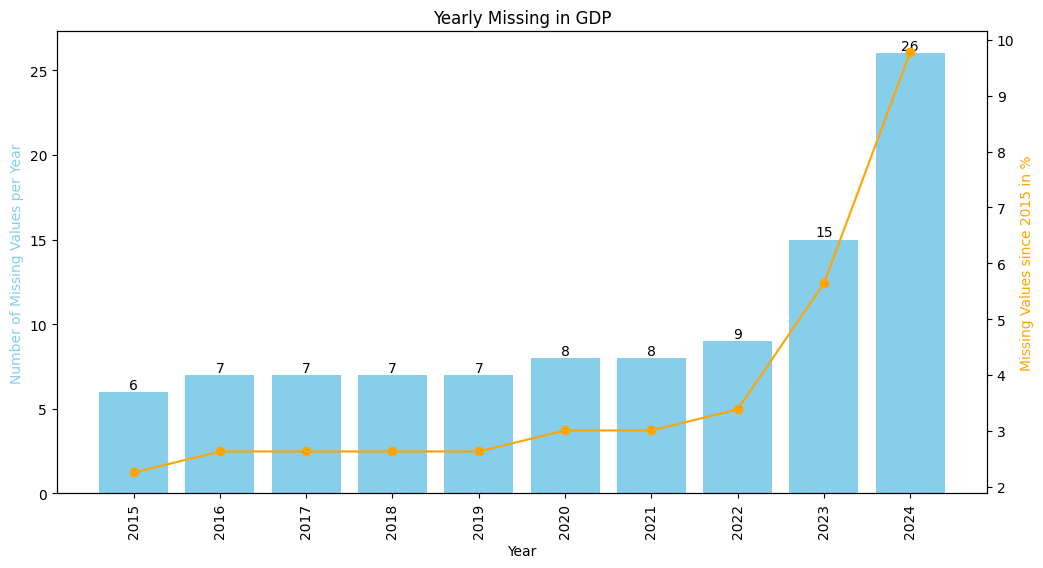

In [16]:
df = get_gdp_per_capita()
plot_missing_gdp(df)

### Cartographie

In [17]:
world_map_gdp(df)

# Statistiques descriptives
---
### Impact du développement économique sur les indicateurs de santé générale et infrastructures

Pour étudier le lien entre développement économique et santé, nous combinons des régressions linéaires entre le PIB et les indicateurs de santé avec des graphiques en barres comparant les pays selon quatre niveaux de revenu (faible à élevé). Nous avons choisi d'utiliser le logarithme du PIB par habitant plutôt que sa valeur brute. Cette transformation est nécessaire pour traiter la forte hétérogénéité entre les pays : les écarts de richesse étant immenses, le logarithme permet de réduire l'influence des valeurs extrêmes et de rendre les données comparables sur une échelle linéaire. 

Les régressions linéaires permettent d’identifier et de quantifier la relation globale entre richesse et santé, en mettant en évidence des tendances générales. Les graphiques par groupes de revenu offrent une lecture plus robuste et intuitive, en réduisant l’influence des valeurs extrêmes et en comparant des niveaux de développement similaires.

L’utilisation conjointe de ces deux approches renforce la fiabilité des résultats : la régression capture la tendance continue, tandis que l’analyse par groupes confirme qu’en passant d’un groupe de pays à l’autre, le développement économique s’accompagne d’une amélioration des indicateurs de santé.

#### Espérance de vie totale

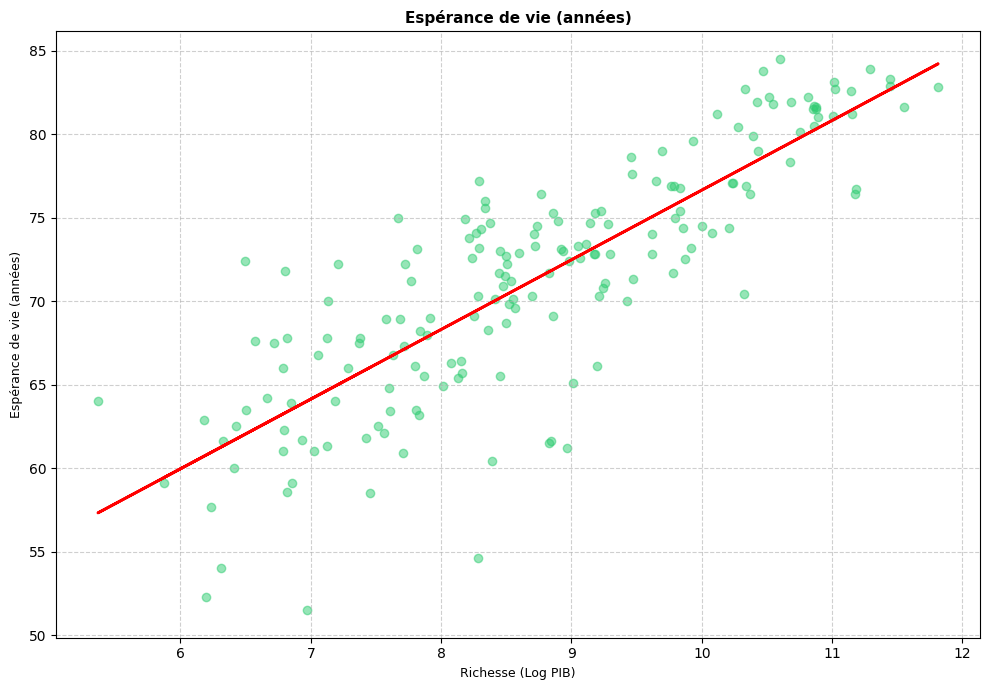


RESUME DES REGRESSIONS

Espérance de vie (années)
----------------------------------------------------------------------
                               OLS Regression Results                              
Dep. Variable:     Espérance de vie totale   R-squared:                       0.690
Model:                                 OLS   Adj. R-squared:                  0.689
Method:                      Least Squares   F-statistic:                     421.5
Date:                     Sat, 27 Dec 2025   Prob (F-statistic):           1.38e-48
Time:                             13:53:38   Log-Likelihood:                -498.56
No. Observations:                      178   AIC:                             1001.
Df Residuals:                          176   BIC:                             1007.
Df Model:                                1                                         
Covariance Type:                       HC1                                         
                 coef    std err      

In [18]:
importlib.reload(gp)
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Espérance de vie totale', 'Espérance de vie (années)', 'regression')
        ],
        disposition="1"
    )

L'analyse de la régression linéaire montre une corrélation positive entre la richesse d'un pays et l'espérance de vie de ses habitants. Une augmentation de 10% du PIB par habitant se traduit par une augmentation de l'espérance de vie d'environ 0,4 an (soit environ 5 mois). Ce résultat semble cohérent, plus un pays se développe économiquement, plus ses citoyens vivent longtemps, car la croissance permet un meilleur accès aux soins, à l'eau potable et à une meilleure alimentation.

Nous avons privilégié l'espérance de vie totale pour sa plus grande robustesse statistique, le PIB expliquant mieux sa variation avec un impact plus marqué (coefficient de 4,17). Contrairement à l'espérance de vie en bonne santé, cet indicateur constitue un standard international fiable reposant sur des données de mortalité précises et objectives. Ce choix permet ainsi une analyse plus rigoureuse et comparable du lien entre croissance économique et survie de la population.

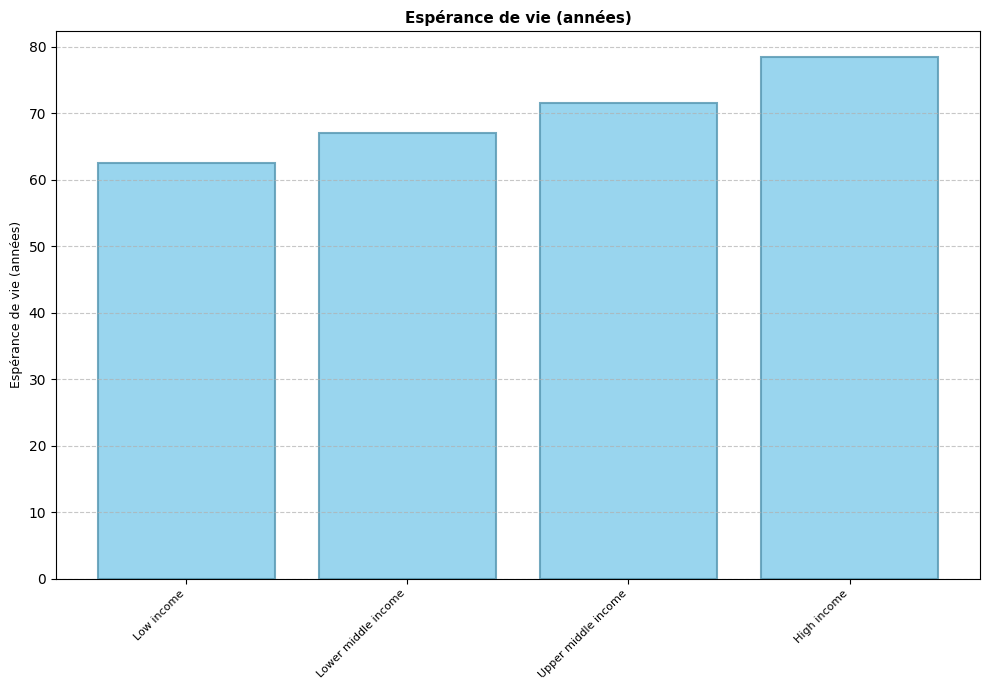


RESUME DES REGRESSIONS

Espérance de vie (années)
----------------------------------------------------------------------
                               OLS Regression Results                              
Dep. Variable:     Espérance de vie totale   R-squared:                       0.690
Model:                                 OLS   Adj. R-squared:                  0.689
Method:                      Least Squares   F-statistic:                     421.5
Date:                     Sat, 27 Dec 2025   Prob (F-statistic):           1.38e-48
Time:                             13:53:38   Log-Likelihood:                -498.56
No. Observations:                      178   AIC:                             1001.
Df Residuals:                          176   BIC:                             1007.
Df Model:                                1                                         
Covariance Type:                       HC1                                         
                 coef    std err      

In [19]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Espérance de vie totale', 'Espérance de vie (années)', 'barres')
        ],
        disposition="1"
    )

Le graphique confirme une corrélation directe entre le niveau de richesse et la longévité : on observe une progression constante de l'espérance de vie à chaque palier de revenu, passant de 62,5 ans pour les pays à faible revenu à plus de 78,4 ans pour les pays à haut revenu. Cet écart massif de près de 16 ans souligne que le développement économique reste un facteur déterminant pour l'amélioration des conditions de santé globales. 

#### Taux de mortalité néonatale et maternelle

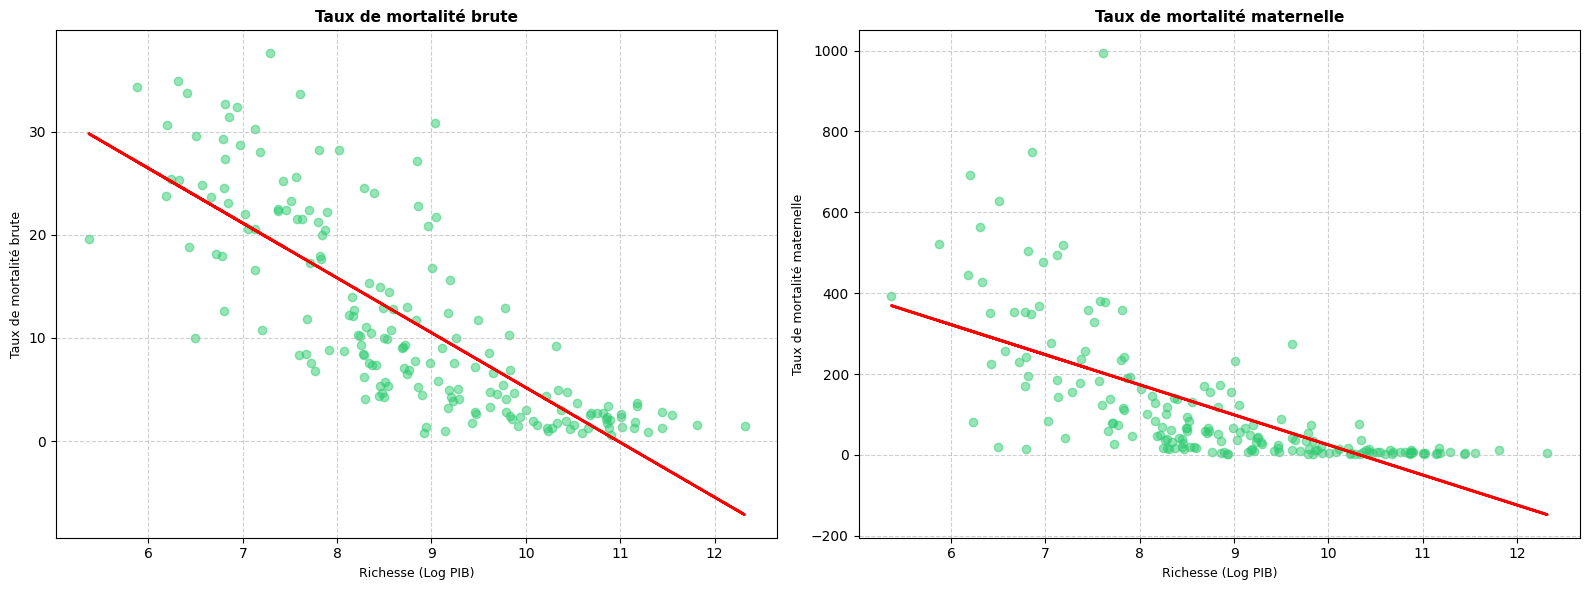


RESUME DES REGRESSIONS

Taux de mortalité brute
----------------------------------------------------------------------
                             OLS Regression Results                             
Dep. Variable:     Taux mortalité brute   R-squared:                       0.617
Model:                              OLS   Adj. R-squared:                  0.615
Method:                   Least Squares   F-statistic:                     324.6
Date:                  Sat, 27 Dec 2025   Prob (F-statistic):           1.76e-42
Time:                          13:53:39   Log-Likelihood:                -597.35
No. Observations:                   186   AIC:                             1199.
Df Residuals:                       184   BIC:                             1205.
Df Model:                             1                                         
Covariance Type:                    HC1                                         
                 coef    std err          z      P>|z|      [0.025    

In [20]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Taux mortalité brute', 'Taux de mortalité brute', 'regression'),
            ('Taux de mortalité maternelle', 'Taux de mortalité maternelle', 'regression')
        ],
        disposition="2"
    )

Ces deux graphiques nous montrent que le développement économique, mesuré par le log du PIB, agit comme un filet de sécurité vital. Cependant, son efficacité diffère : il est un prédicteur plus robuste pour la survie des nouveau-nés ($R^2$=0.63), que pour celle des mères ($R^2$=0.43).
Le coefficient négatif significatif dans les deux modèles confirme qu'une croissance économique soutenue est indispensable pour réduire le taux de mortalité néonatale. 

Mais la plus faible part de variance expliquée pour la mortalité maternelle souligne que la richesse du pays n'est pas le seul facteur, elle doit être accompagnée de politiques publiques ciblées sur l'accès aux soins d'urgence pour être pleinement efficace.
Ainsi, ces deux indicateurs sont complémentaires : la mortalité néonatale reflète le niveau d'équipement médical de base d'un pays, tandis que la mortalité maternelle révèle les limites de la croissance économique seule face aux enjeux d'organisation structurelle de la santé.

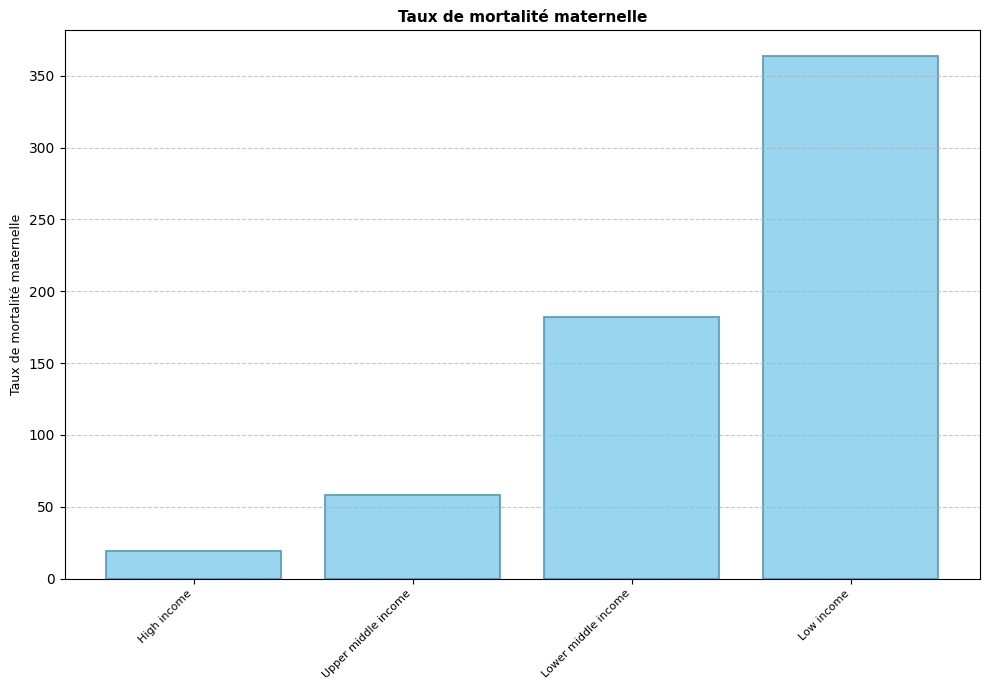


RESUME DES REGRESSIONS

Taux de mortalité maternelle
----------------------------------------------------------------------
                                 OLS Regression Results                                 
Dep. Variable:     Taux de mortalité maternelle   R-squared:                       0.437
Model:                                      OLS   Adj. R-squared:                  0.434
Method:                           Least Squares   F-statistic:                     102.1
Date:                          Sat, 27 Dec 2025   Prob (F-statistic):           2.17e-19
Time:                                  13:53:39   Log-Likelihood:                -1162.4
No. Observations:                           187   AIC:                             2329.
Df Residuals:                               185   BIC:                             2335.
Df Model:                                     1                                         
Covariance Type:                            HC1                           

In [21]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Taux de mortalité maternelle', 'Taux de mortalité maternelle', 'barres')
        ],
        disposition="1"
    )

Ce graphique en bâtons révèle un "effet de seuil" notable : le simple passage du groupe à faible revenu (Low income) au groupe intermédiaire inférieur (Lower middle income) permet de diviser par deux le taux de mortalité maternelle. Cela suggère que les investissements de base dans les soins obstétricaux d'urgence, rendus possibles par les premiers paliers de croissance, sont les plus importants.
De plus, on observe une décroissance exponentielle de la mortalité : si la richesse réduit le nombre de décès à chaque palier, l'écart massif de plus de 300 points entre les extrêmes souligne que la survie des mères reste l'indicateur le plus durement marqué par l'inégalité économique mondiale.

#### Infrastructures de soin et état de santé des populations

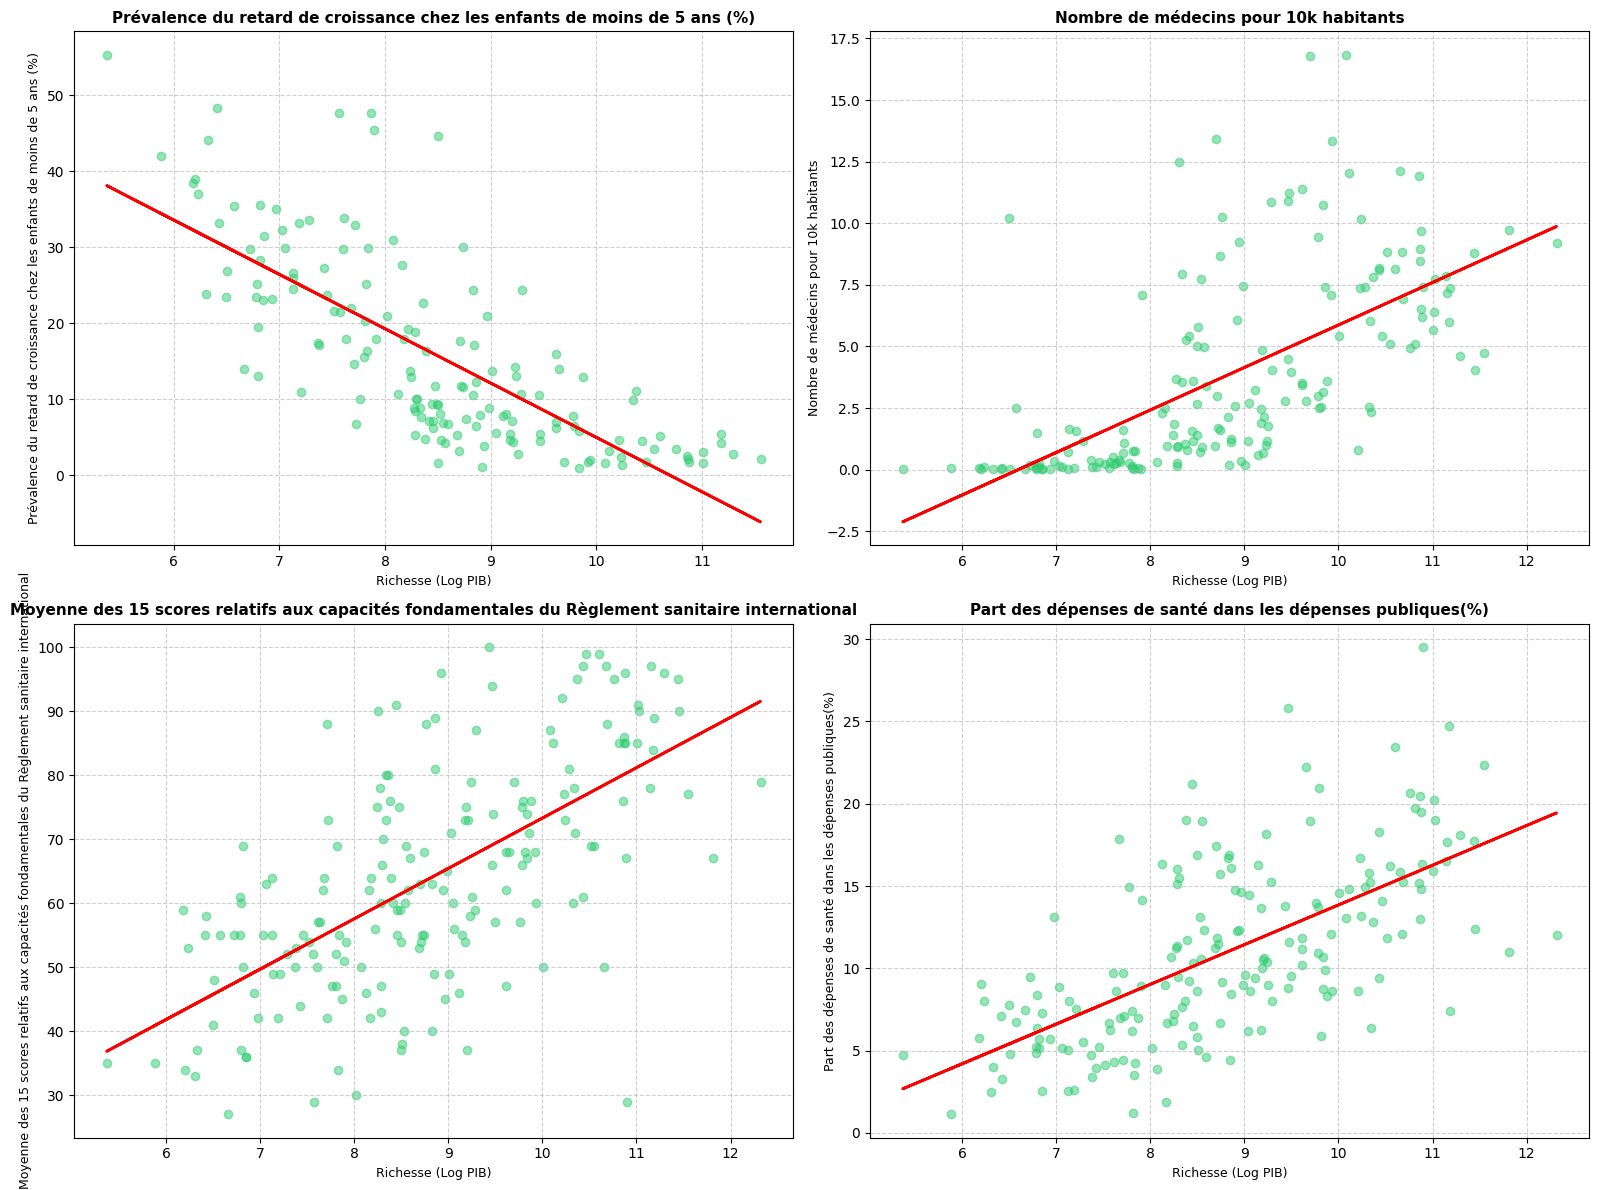


RESUME DES REGRESSIONS

Prévalence du retard de croissance chez les enfants de moins de 5 ans (%)
----------------------------------------------------------------------
                                OLS Regression Results                               
Dep. Variable:     Retard croissance enfants   R-squared:                       0.562
Model:                                   OLS   Adj. R-squared:                  0.559
Method:                        Least Squares   F-statistic:                     230.4
Date:                       Sat, 27 Dec 2025   Prob (F-statistic):           2.92e-32
Time:                               13:53:39   Log-Likelihood:                -543.31
No. Observations:                        154   AIC:                             1091.
Df Residuals:                            152   BIC:                             1097.
Df Model:                                  1                                         
Covariance Type:                         HC1            

In [22]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Retard croissance enfants', 'Prévalence du retard de croissance chez les enfants de moins de 5 ans (%)', 'regression'),
            ('Médecins pour 10k habitants', 'Nombre de médecins pour 10k habitants', 'regression'),
            ('Capacité réponse sanitaire', 'Moyenne des 15 scores relatifs aux capacités fondamentales du Règlement sanitaire international', 'regression'),
            ('Dépenses publiques santé', 'Part des dépenses de santé dans les dépenses publiques(%)', 'regression')
        ],
        disposition="4")

L'analyse combinée de ces quatre indicateurs de santé par rapport au niveau de richesse du pays montre une hiérarchie claire : le PIB est un moteur puissant pour les besoins vitaux primaires (diminution du retard de croissance), mais il devient un facteur secondaire lorsqu'il s'agit de structurer l'offre de soins (médecins, dépenses publiques).
Le faible $R^2$ des dépenses de santé (0.40) par rapport à celui du retard de croissance (0.61) prouve que si la richesse aide à nourrir une population, elle ne dicte pas automatiquement la qualité des politiques de santé publique.
Ainsi, le développement économique est une condition nécessaire pour sortir de l'urgence sanitaire, mais il est insuffisant pour bâtir un système de santé complet sans une volonté politique forte et durable.

Contrairement à d'autres indicateurs, le retard de croissance présente une progression en escalier quasi parfaite. Cette réduction systématique de la prévalence à chaque palier de revenu confirme que le développement économique agit comme un levier direct et constant sur la sécurité alimentaire et l'hygiène infantile.

---

### Impact du développement économique sur les indicateurs de santé mentale

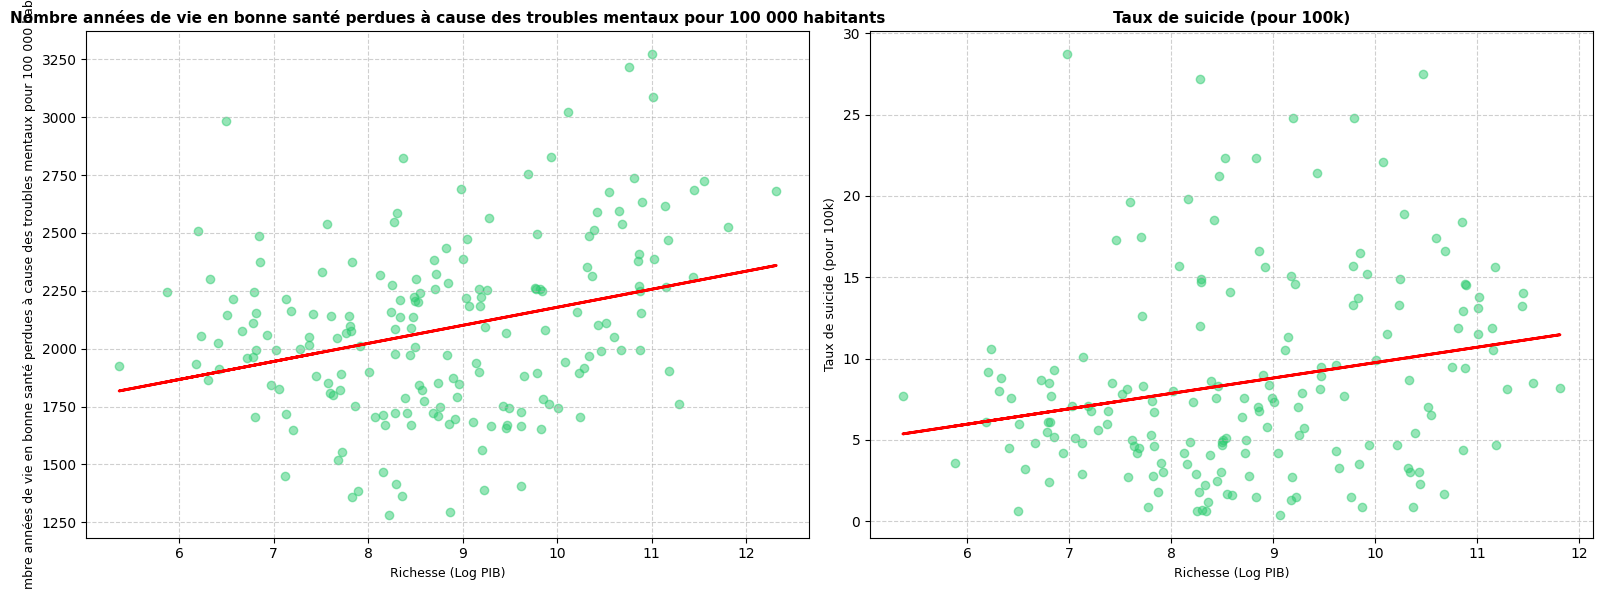


RESUME DES REGRESSIONS

Nombre années de vie en bonne santé perdues à cause des troubles mentaux pour 100 000 habitants
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:       Mental_disorders   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     17.64
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           4.14e-05
Time:                        13:53:40   Log-Likelihood:                -1364.6
No. Observations:                 187   AIC:                             2733.
Df Residuals:                     185   BIC:                             2740.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 c

In [23]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Mental_disorders', 'Nombre années de vie en bonne santé perdues à cause des troubles mentaux pour 100 000 habitants', 'regression'),
            ('Taux de suicides', 'Taux de suicide (pour 100k)', 'regression')
        ],
        disposition="2"
    )

L'analyse de la santé mentale marque une rupture nette avec nos observations précédentes. Pour la première fois, l'augmentation du PIB n'entraîne pas une amélioration des indicateurs : les troubles mentaux et le taux de suicide affichent des corrélations positives avec la richesse nationale.
Le très faible $R^2$ du taux de suicide (0.05) souligne que le développement économique n'agit pas comme un bouclier contre la détresse psychologique : ce phénomène échappe à la logique financière pour relever de facteurs culturels et sociaux profonds. Parallèlement, la corrélation positive observée pour les troubles mentaux ne traduit pas nécessairement une dégradation de la santé mentale dans les pays riches, mais plutôt une meilleure capacité de diagnostic. Là où un pays pauvre se concentre sur les urgences vitales, un pays développé dispose des infrastructures nécessaires pour identifier et comptabiliser l'anxiété ou la dépression. 

Ces résultats suggèrent donc que si le développement économique parvient à soigner les corps et à prolonger la vie, il ne répond pas automatiquement au bien-être de l'esprit. La santé mentale apparaît comme le "point mort" de la croissance économique, nécessitant des politiques sociales et humaines qui dépassent la simple accumulation de richesses.

---

### Impact du développement économique sur les indicateurs de santé alimentaire

---

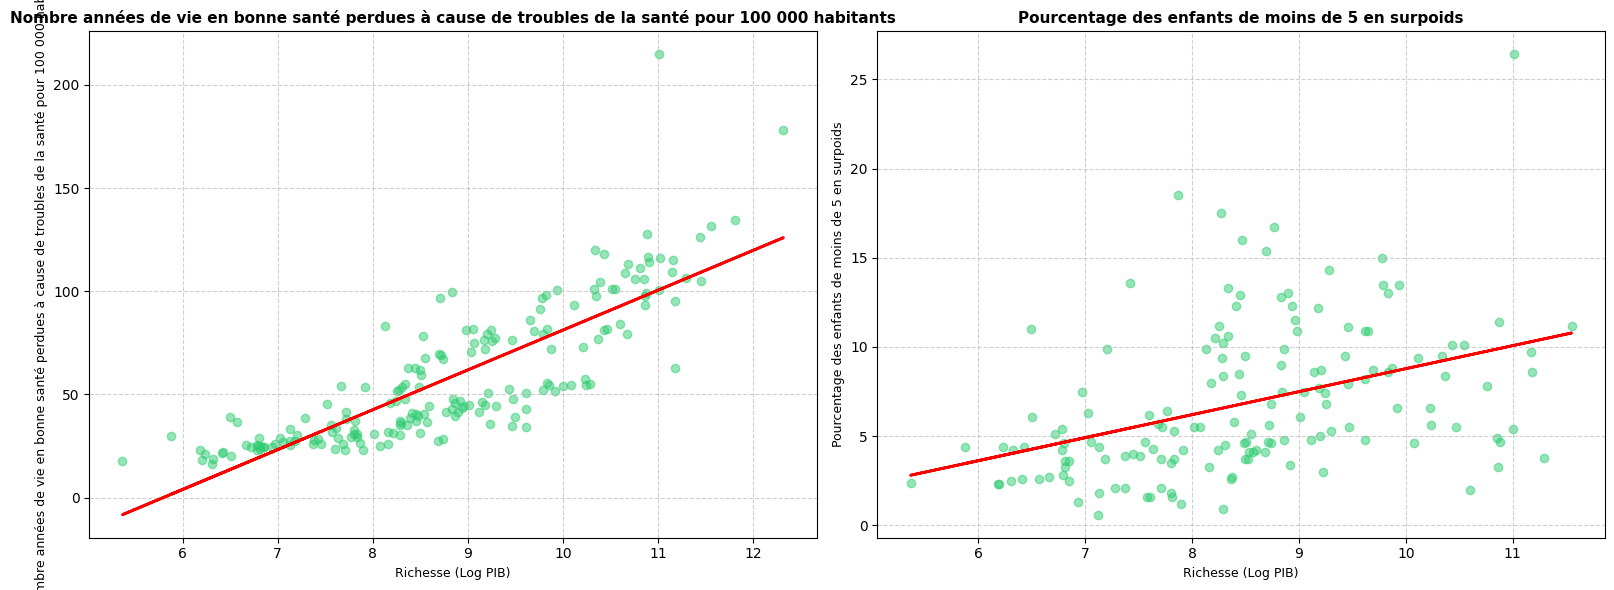


RESUME DES REGRESSIONS

Nombre années de vie en bonne santé perdues à cause de troubles de la santé pour 100 000 habitants
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:       Eating_disorders   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     293.9
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           4.61e-40
Time:                        13:53:40   Log-Likelihood:                -812.53
No. Observations:                 187   AIC:                             1629.
Df Residuals:                     185   BIC:                             1636.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
               

In [24]:
gp.afficher_graphiques(
        liste_indicateurs=[
            ('Eating_disorders', 'Nombre années de vie en bonne santé perdues à cause de troubles de la santé pour 100 000 habitants', 'regression'),
            ('Surpoids enfants <5 ans', 'Pourcentage des enfants de moins de 5 en surpoids', 'regression')
        ],
        disposition="2"
    )

On constate que l'augmentation du PIB par habitant agit comme un moteur de la transition nutritionnelle : si elle réduit la faim, elle déplace les enjeux sanitaires vers de nouvelles problématiques.
Sur le surpoids infantile : le développement économique favorise l'accès à une alimentation plus abondante mais souvent trop calorique (produits ultra-transformés), faisant du PIB un contributeur significatif, bien que partiel, de l'obésité précoce.
Sur les troubles alimentaires : Le lien est ici structurel et massif ($R^2$ de 69%). La richesse d'un pays s'accompagne d'une explosion de ces diagnostics, poussée par une pression sociale accrue et des systèmes de santé plus performants pour les identifier.
Ainsi, la croissance économique marque le passage de pathologies de "carence" à des pathologies de "surconsommation" et d'ordre psychologique, imposant des politiques publiques ciblées dès que le niveau de vie s'élève.

## Question de la réciprocité du lien économie-santé : les indicateurs sanitaires stimulent-ils la croissance économique?
#### Modèle de régression linéaire multiple


--- REGRESSION MULTIPLE : SANTE -> PIB (2021) ---
Nombre de pays : 176

Modèle : Log(PIB) = β0 + β1×Espérance + β2×Mortalité + β3×Dépenses

                            OLS Regression Results                            
Dep. Variable:                   2021   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     196.4
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           2.58e-55
Time:                        13:55:11   Log-Likelihood:                -192.91
No. Observations:                 176   AIC:                             393.8
Df Residuals:                     172   BIC:                             406.5
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                               coef    std err          z      P>|z| 

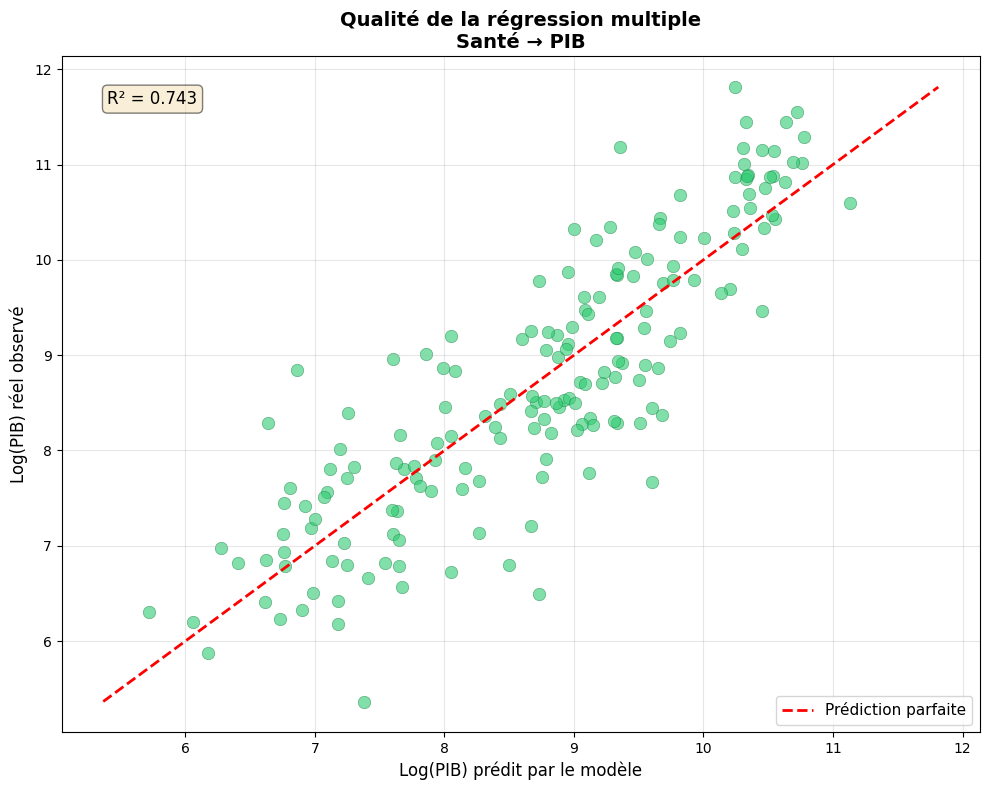

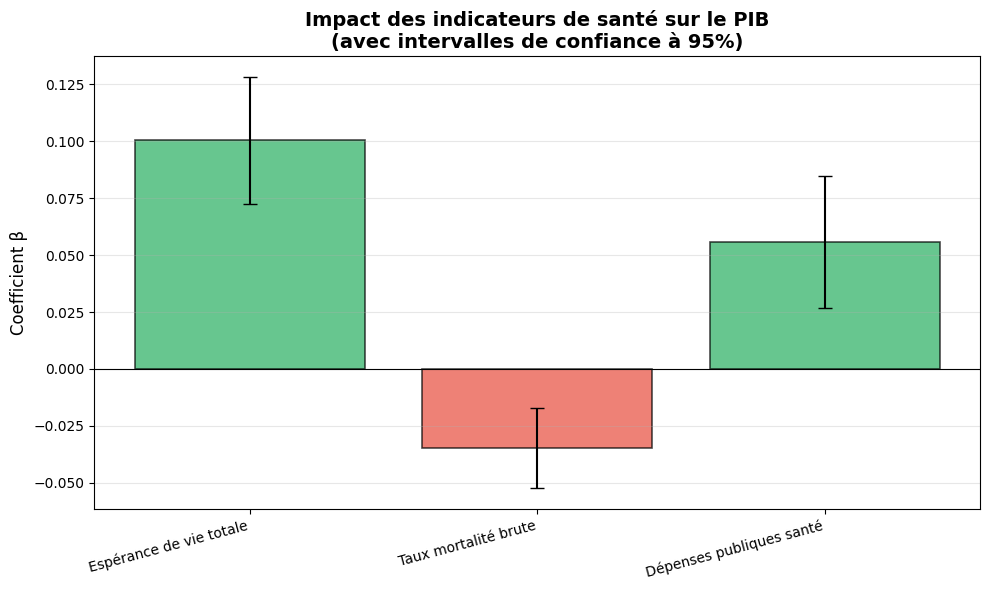

In [27]:
chemin = "Table_complète.csv"
df = pd.read_csv(chemin)

model, df_clean = analyse_sante_vers_pib(df)
graphique_valeurs_predites_vs_reelles(model, df_clean)
graphique_coefficients(model)

L’analyse de notre modèle de régression multiple révèle une dépendance fondamentale entre la santé des populations et la performance économique nationale. Avec un coefficient de détermination $R^2$ de 0,743, notre modèle démontre que plus de 74 % de la variation du PIB mondial s'explique par seulement trois indicateurs sanitaires. La robustesse statistique globale (p-value quasi nulle) confirme que la santé n'est pas une simple conséquence de la richesse, mais un moteur déterminant de celle-ci.

Le choix des variables repose sur une vision complète du capital humain : l’espérance de vie mesure la viabilité à long terme de la force de travail, le taux de mortalité reflète la résilience face aux crises sanitaires, et les dépenses de santé traduisent l’engagement politique dans la protection des citoyens. Ces trois piliers forment un indicateur composite de la "santé économique" d'un pays, prouvant que le développement humain est indissociable du développement financier.

Les résultats soulignent l’influence prédominante de la longévité. Le modèle indique qu’une augmentation d’une seule année d'espérance de vie est associée à une hausse moyenne de 10 % du PIB. Ce gain massif s'explique par l'accumulation d'expérience, une productivité accrue et une meilleure stabilité sociale. À l'inverse, la mortalité agit comme un frein direct : chaque point supplémentaire de mortalité brute ampute le PIB d'environ 3,5 %, illustrant le coût économique des décès prématurés.

Enfin, l'étude valide la pertinence des politiques budgétaires de santé. Une hausse d'un point des dépenses publiques de santé dans le PIB génère mécaniquement une croissance de 5,6 % du PIB total. Ces données transforment la perception des budgets de santé : ils ne doivent plus être vus comme des coûts de fonctionnement, mais comme des investissements stratégiques à haut rendement. En somme, notre analyse prouve qu’investir dans le bien-être physique des citoyens est l’une des stratégies les plus efficaces pour garantir la prospérité économique d'un pays.